# Messing around with location history

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
# !pip install plotly chart-studio

In [3]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [4]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = detective.db_from_hass_config(fetch_entities=False)

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db


First we extract all state changes for Gaby and Charles

In [5]:
people = ("person.charles","person.gaby",)

In [6]:
# Copied from HASS-data-detective and modified to join the new attributes table
sensors_str = str(tuple(people))
if len(people) == 1:
    sensors_str = sensors_str.replace(",", "")

query = f"""
    SELECT domain, entity_id, state, last_changed, shared_attrs
    FROM states
    LEFT JOIN state_attributes ON states.attributes_id = state_attributes.attributes_id
    WHERE
        entity_id IN {sensors_str}
    AND
        state NOT IN ('unknown', 'unavailable')
    ORDER BY last_changed DESC
    """

results = pd.read_sql_query(query, db.url)
print(f"{len(results)} results loaded")
results

39601 results loaded


,domain,entity_id,state,last_changed,shared_attrs
0,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
1,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
3,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
4,None,person.gaby,home,2022-10-14 21:50:50.483046,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
...,...,...,...,...,...
39596,None,person.gaby,home,2022-05-05 20:13:55.110599,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39597,None,person.gaby,home,2022-05-05 20:13:55.110599,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39598,None,person.gaby,home,2022-05-05 20:13:55.110599,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
39599,None,person.gaby,home,2022-05-05 20:13:55.110599,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


In [7]:
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

,domain,entity_id,state,shared_attrs
time,,,,
2022-05-05 20:13:55.110599,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-05 20:13:55.110599,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-05 20:13:55.110599,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-05 20:13:55.110599,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-05-05 20:13:55.110599,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
...,...,...,...,...
2022-10-14 21:50:50.483046,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-10-14 21:50:50.483046,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-10-14 21:50:50.483046,None,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


In [8]:
import yaml
l = lambda s : yaml.safe_load(s)
results["parsed_attrs"] = results.loc[:, "shared_attrs"].apply(l)

In [19]:
results['latitude'] = results['parsed_attrs'].apply(lambda i : i['latitude'])
results['longitude'] = results['parsed_attrs'].apply(lambda i : i['longitude'])

In [ ]:
results_unfiltered = results.copy()
results = results[

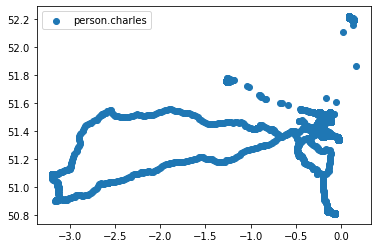

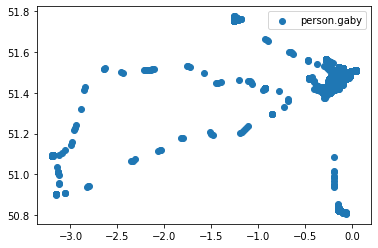

In [17]:
import matplotlib.pyplot as plt

for person in people:
    plt.figure()
    k = (results["entity_id"] == person) & (results["longitude"] > -20)
    plt.scatter(results.loc[k, 'longitude'], results.loc[k, 'latitude'])
    plt.legend([person])
# results.plot.scatter(x="longitude", y="latitude", alpha=0.4, label="entity_id");

In [11]:
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

coords = pd.concat([results['latitude'], results['longitude']], axis=1)
coords = coords.sample(frac=0.1, replace=True)

colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']

points = go.Scattergeo(
    lon = coords['longitude'],
    lat = coords['latitude']
)


layout = go.Layout(
    title = 'Hey look! It\'s a scatter plot on a map!',
    geo = dict(
        # resolution = 110,
        scope = 'europe',
        # showframe = True,
        # showcoastlines = True,
        # showland = True,
        # landcolor = "rgb(229, 229, 229)",
        # countrycolor = "rgb(255, 255, 255)" ,
        # coastlinecolor = "rgb(255, 255, 255)",
        # projection = dict(
        #     type = 'mercator'
        # ),
        # lonaxis = dict( range= [ -124.0, -113.0 ] ),
        # lataxis = dict( range= [ 32.0, 43.0 ] ),
        
    ),
    legend = dict(
           traceorder = 'reversed'
    )
)


fig = go.Figure(layout=layout, data=points)
plotly.offline.iplot(fig, validate=False)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df, locations="iso_alpha",
                     size="pop", # size of markers, "pop" is one of the columns of gapminder
                     )
fig.show()

In [ ]:
coords